In [3]:
import numpy as np

from skimage.io import imread
from skimage.color import rgb2gray

from matplotlib import pyplot as plt

from tqdm import trange
from tqdm.auto import tqdm

In [313]:
def convert_img_to_mask(img):
    return ((img[:, :, 0] != 0) * -1 + (img[:, :, 1] != 0)).astype('int8')

input_path = 'public_tests/05_test_img_input/'
#gt_path = 'public_tests/01_test_img_input/'

img = imread(input_path + 'img.png')
mask = convert_img_to_mask(imread(input_path + 'mask.png'))
img.shape, mask.shape

((198, 512, 3), (198, 512))

In [6]:
def draw_img(img):
    plt.figure(figsize=(20, 8))
    if len(img.shape) == 3 and img.shape[2] == 3:
        plt.imshow(img, cmap='gray')
        plt.show()
    elif len(img.shape) == 2:
        img_copy = img.copy()
        img_copy[0, 0] = 0
        img_copy[0, 1] = 1
        plt.imshow(img_copy, cmap='gray')
        plt.show()
    else:
        raise ValueError

In [291]:
import numpy as np


def compute_brightness(img):
    return 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]

def compute_energy_x(img):
    assert len(img.shape) == 2
    return np.hstack((
        img[:, 1:], 
        img[:, -1].reshape(-1, 1)
    )) - np.hstack((
        img[:, 0].reshape(-1, 1), 
        img[:, :-1]
    ))

def compute_energy_y(img):
    assert len(img.shape) == 2
    return np.vstack((
        img[1:, :], 
        img[-1, :].reshape(1, -1)
    )) - np.vstack((
        img[0, :].reshape(1, -1), 
        img[:-1, :]
    ))

def compute_energy(img, mask):
    img_br = compute_brightness(img)
    result = np.sqrt(compute_energy_x(img_br) ** 2 + compute_energy_y(img_br) ** 2) + 256 * img.shape[0] * img.shape[1] * mask
    result -= result.min()
    result /= result.max()
    return result

def compute_hseam(img, mask):
    e = compute_energy(img, mask)
    
    dp = np.zeros(e.shape)
    dpj = np.zeros(e.shape, dtype=int)
    dp[0, :] = e[0, :]
    
    h, w = dp.shape
    for i in range(1, h):
        ind = np.argmin(dp[i - 1, 0:2])
        dpj[i, 0] = ind
        dp[i, 0] = dp[i - 1, dpj[i, 0]] + e[i, 0]
        for j in range(1, w-1):
            #ind = np.argmin(dp[i - 1, max(0, j - 1):min(j + 2, w)])
            #ind = dp[i - 1, j - 1:j + 2].argmin()
            ind = 0
            if dp[i - 1, j] < dp[i - 1, j - 1 + ind]:
                ind = 1
            if dp[i - 1, j + 1] < dp[i - 1, j - 1 + ind]:
                ind = 2
            
            dpj[i, j] = j - 1 + ind
            dp[i, j] = dp[i - 1, dpj[i, j]] + e[i, j]
        ind = np.argmin(dp[i - 1, w-2:w])
        dpj[i, w - 1] = w - 2 + ind
        dp[i, w - 1] = dp[i - 1, dpj[i, w - 1]] + e[i, w - 1]
    
    seam = np.zeros(h, dtype=int)
    seam[-1] = dp[-1, :].argmin()
    for j in range(h - 2, -1, -1):
        seam[j] = dpj[j + 1, seam[j + 1]]
    
    return seam

def compute_hseam_mask(seam, shape):
    seam_mask = np.zeros(shape)
    for i in range(shape[0]):
        seam_mask[i, seam[i]] = 1
    return seam_mask

def carve_hseam_img(img, seam):
    result = np.zeros(img.shape - np.array([0, 1, 0]))
    for i in range(img.shape[0]):
        result[i, :seam[i], :] = img[i, :seam[i], :]
        result[i, seam[i]:, :] = img[i, seam[i]+1:, :]
    return result
    
def carve_hseam_mask(mask, seam):
    result = np.zeros(mask.shape - np.array([0, 1]))
    for i in range(mask.shape[0]):
        result[i, :seam[i]] = mask[i, :seam[i]]
        result[i, seam[i]:] = mask[i, seam[i]+1:]
    return result

def expand_hseam_img(img, seam):
    result = np.zeros(img.shape + np.array([0, 1, 0]))
    for i in range(img.shape[0]):
        j = seam[i]
        assert 0 <= j < img.shape[1]
        
        if j == 0:
            result[i, 0, :] = img[i, 0, :]
            result[i, 1:, :] = img[i, 0:, :]
            continue
        if j == img.shape[1] - 1:
            result[i, :-1, :] = img[i, :, :]
            result[i, -1:, :] = img[i, -1:, :]
            continue
        
        result[i, :j+1, :] = img[i, :j+1, :]
        result[i, j + 1, :] = img[i, j:j + 2, :].mean(axis=0)
        result[i, j+2:, :] = img[i, j+1:, :]
    return result

def expand_hseam_mask(mask, seam):
    result = np.zeros(mask.shape + np.array([0, 1]))
    for i in range(mask.shape[0]):
        j = seam[i]
        assert 0 <= j < mask.shape[1]
        
        if j == 0:
            result[i, 0] = mask[i, 0]
            result[i, 1:] = mask[i, 0:]
            continue
        if j == mask.shape[1] - 1:
            result[i, :-1] = mask[i, :]
            result[i, -1:] = mask[i, -1:]
            continue
        
        result[i, :j+1] = mask[i, :j+1]
        result[i, j + 1] = mask[i, j:j + 2].mean()
        result[i, j+2:] = mask[i, j+1:]
    return result

def seam_carve(img, mode, mask=None):
    # img = img.astype(np.float32) / 255.
    
    if mask is None:
        mask = np.zeros(img.shape[:2])
    
    if mode == 'horizontal shrink':
        print('hs', end=' ')

        seam = compute_hseam(img, mask)
        
        res_img = carve_hseam_img(img, seam)
        res_mask = carve_hseam_mask(mask, seam)
        seam_mask = compute_hseam_mask(seam, img.shape[:2])
        return res_img, res_mask, seam_mask
    
    if mode == 'vertical shrink':
        print('vs', end=' ')
        
        img = img.transpose(1, 0, 2)
        mask = mask.transpose(1, 0)
        
        seam = compute_hseam(img, mask)

        res_img = carve_hseam_img(img, seam).transpose(1, 0, 2)
        res_mask = carve_hseam_mask(mask, seam).transpose(1, 0)
        seam_mask = compute_hseam_mask(seam, img.shape[:2]).transpose(1, 0)
        return res_img, res_mask, seam_mask
        
    if mode == 'horizontal expand':
        print('he', end=' ')
        
        seam = compute_hseam(img, mask)
        
        res_img = expand_hseam_img(img, seam)
        res_mask = expand_hseam_mask(mask, seam)
        seam_mask = compute_hseam_mask(seam, img.shape[:2])
        
        return res_img, res_mask, seam_mask
    
    if mode == 'vertical expand':
        print('ve', end=' ')
        
        img = img.transpose(1, 0, 2)
        mask = mask.transpose(1, 0)
        
        seam = compute_hseam(img, mask)
        
        res_img = expand_hseam_img(img, seam).transpose(1, 0, 2)
        res_mask = expand_hseam_mask(mask, seam).transpose(1, 0)
        seam_mask = compute_hseam_mask(seam, img.shape[:2]).transpose(1, 0)
    
        return res_img, res_mask, seam_mask
    
    raise "unk"


In [292]:
seam = compute_hseam(img, mask)

res_img = carve_hseam_img(img, seam)
seam_mask = compute_hseam_mask(seam, img.shape[:2])

In [293]:
modes = [
    'horizontal shrink',
    'vertical shrink',
    'horizontal expand',
    'vertical expand',
]

he 

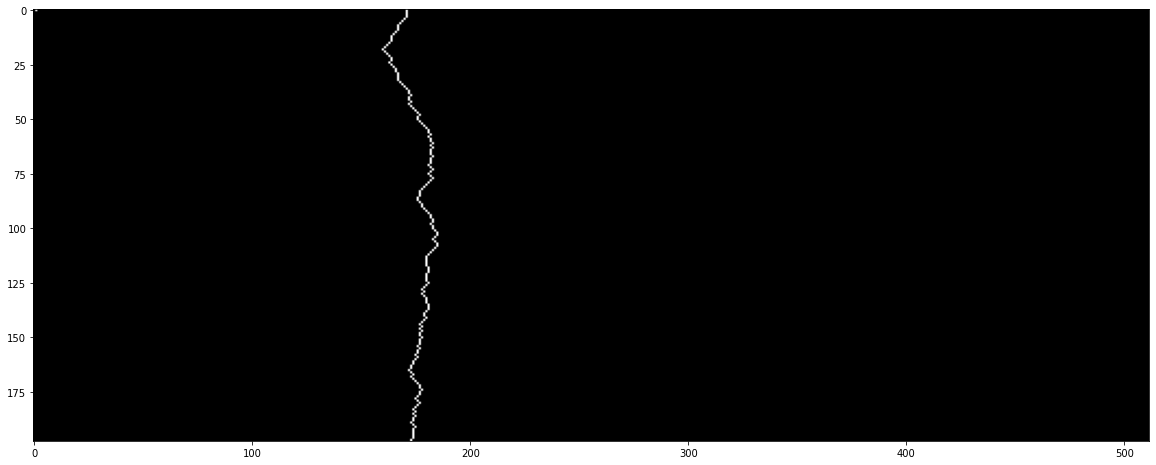

(198, 513, 3)

In [294]:
res, res_mask, seam_mask = seam_carve(img, mode=modes[2], mask=mask)
draw_img(seam_mask)
res.shape

ve 

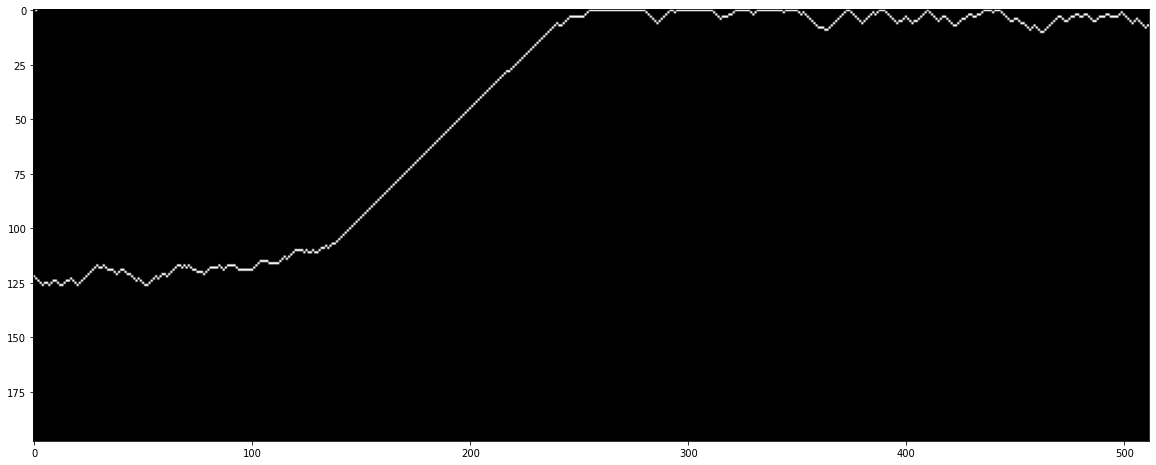

In [295]:
res, _, seam_mask = seam_carve(img, mode=modes[3], mask=mask)
draw_img(seam_mask)

In [296]:
from pickle import load

In [297]:
check_path = 'public_tests/05_test_img_check/'
output_seams_path = check_path + 'output/output_seams'
seams_path = check_path + 'gt/seams'
output_seams_path

'public_tests/05_test_img_check/output/output_seams'

In [298]:
with open(output_seams_path, 'rb') as fout, open(seams_path, 'rb') as fgt:
    for i in range(8):
        output_seam = np.array(load(fout))
        correct_seam = np.array(load(fgt))
        if (output_seam == correct_seam).all():
            print('+', end=' ')
        else:
            print('-', end=' ')
        break

- 

In [299]:
(output_seam - correct_seam)[185:187, :]

array([[0, 1],
       [0, 1]])

In [300]:
output_seam[185:187, :], correct_seam[185:187, :], 

(array([[185, 449],
        [186, 448]]),
 array([[185, 448],
        [186, 447]]))

In [301]:
img.shape

(198, 512, 3)

In [311]:
e = compute_energy(img, np.zeros(img.shape[:2]))
e[185:187, 447:450]
e[185, 448], e[185, 449]

(0.003184521617207402, 0.003184521617207221)

In [303]:
compute_hseam(img, np.zeros(img.shape[:2]))[185:187]

array([449, 448])

In [304]:
img.dtype

dtype('uint8')

In [305]:
e = compute_energy(img, mask).ravel()
e.sort()
d = np.absolute(e[:1] - e[:-1])
d.sort()
d = d[d > 0]
d[:10]

array([3.44223605e-10, 9.75401126e-10, 6.46819997e-09, 7.36755805e-09,
       9.70470951e-09, 1.14929362e-08, 1.24687172e-08, 1.32464843e-08,
       1.34006126e-08, 1.35223733e-08])

In [263]:
d

array([-1.])